In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load ground truth
ground_truth = pd.read_csv('ground_truth.csv')

# Load model outputs in a dictionary {model_name: df}
model_files = {
    'Model_1': 'model1.csv',
    'Model_2': 'model2.csv',
    'Model_3': 'model3.csv',
}

model_outputs = {name: pd.read_csv(path) for name, path in model_files.items()}


In [3]:
def evaluate_model(gt_df, pred_df, include_demographics=False):
    """
    Compute precision, recall, f1, accuracy per attribute.

    Parameters:
    - gt_df: Ground truth DataFrame
    - pred_df: Model predictions DataFrame
    - include_demographics: bool, whether to include demographic columns (age, gender)

    Returns:
    - DataFrame with metrics per attribute
    """
    # Define columns to always exclude (identifiers)
    exclude_cols = ['case_id']

    # Base clinical attributes to evaluate
    clinical_attrs = ['comorbidity_diabetes', 'comorbidity_hypertension', 'medication_aspirin', 'mortality_30_day']
    demographics = ['age', 'gender']

    # Build list of columns to evaluate
    if include_demographics:
        eval_columns = clinical_attrs + demographics
    else:
        eval_columns = clinical_attrs

    results = []
    for attr in eval_columns:
        if attr not in gt_df.columns or attr not in pred_df.columns:
            continue  # skip if attribute missing in either df

        y_true = gt_df[attr]
        y_pred = pred_df[attr]

        # Handle numeric (age) and categorical differently
        if attr == 'age':
            # For numeric, compute e.g. mean absolute error (MAE)
            from sklearn.metrics import mean_absolute_error
            mae = mean_absolute_error(y_true, y_pred)
            # For consistency, store MAE under 'Error' and leave others NaN
            results.append({
                'Attribute': attr,
                'Precision': np.nan,
                'Recall': np.nan,
                'F1': np.nan,
                'Accuracy': np.nan,
                'MAE': mae
            })
        elif attr == 'gender':
            # For categorical gender, treat as classification, encode if necessary
            # Encode gender as integers for metric computation
            gender_map = {'Male': 0, 'Female': 1}
            y_true_enc = y_true.map(gender_map)
            y_pred_enc = y_pred.map(gender_map)
            precision = precision_score(y_true_enc, y_pred_enc, zero_division=0)
            recall = recall_score(y_true_enc, y_pred_enc, zero_division=0)
            f1 = f1_score(y_true_enc, y_pred_enc, zero_division=0)
            accuracy = accuracy_score(y_true_enc, y_pred_enc)
            results.append({
                'Attribute': attr,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Accuracy': accuracy,
                'MAE': np.nan
            })
        else:
            # Binary clinical attributes
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            accuracy = accuracy_score(y_true, y_pred)
            results.append({
                'Attribute': attr,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Accuracy': accuracy,
                'MAE': np.nan
            })
    return pd.DataFrame(results)


In [4]:
metrics_df = evaluate_model(ground_truth, model_outputs['Model_1'], True)

In [5]:
metrics_df

,Attribute,Precision,Recall,F1,Accuracy,MAE
0,comorbidity_diabetes,1.0,0.888889,0.941176,0.933333,NaN
1,comorbidity_hypertension,1.0,0.777778,0.875000,0.866667,NaN
2,medication_aspirin,1.0,1.000000,1.000000,1.000000,NaN
3,mortality_30_day,1.0,0.200000,0.333333,0.733333,NaN
4,age,NaN,NaN,NaN,NaN,0.0
5,gender,1.0,1.000000,1.000000,1.000000,NaN


In [6]:
metrics_dfs = {}

for model_name, pred_df in model_outputs.items():
    metrics_df = evaluate_model(ground_truth, pred_df, True)
    metrics_df['Model'] = model_name
    metrics_dfs[model_name] = metrics_df

# Combine all results into one DataFrame
combined_metrics = pd.concat(metrics_dfs.values(), ignore_index=True)


In [7]:
# Pivot for better readability: rows=Attributes, columns=Model + metric
summary_table = combined_metrics.pivot(index='Attribute', columns='Model')
print(summary_table)

                         Precision                      Recall          \
Model                      Model_1   Model_2 Model_3   Model_1 Model_2   
Attribute                                                                
age                            NaN       NaN     NaN       NaN     NaN   
comorbidity_diabetes           1.0  0.818182   1.000  0.888889     1.0   
comorbidity_hypertension       1.0  0.600000   1.000  0.777778     1.0   
gender                         1.0  1.000000   1.000  1.000000     1.0   
medication_aspirin             1.0  1.000000   0.875  1.000000     1.0   
mortality_30_day               1.0  0.000000   1.000  0.200000     0.0   

                                          F1                    Accuracy  \
Model                      Model_3   Model_1 Model_2   Model_3   Model_1   
Attribute                                                                  
age                            NaN       NaN     NaN       NaN       NaN   
comorbidity_diabetes      0.7

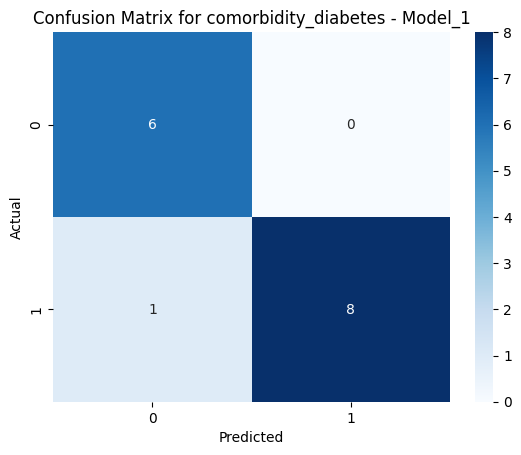

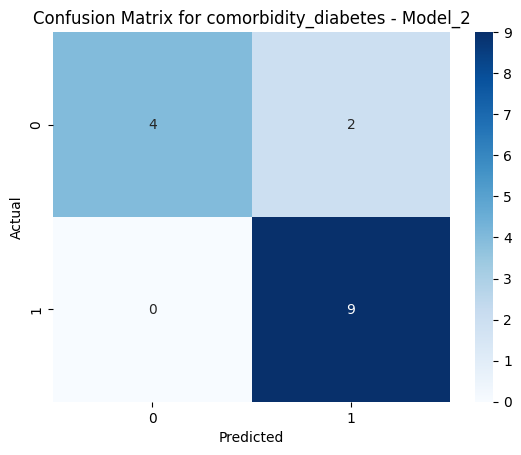

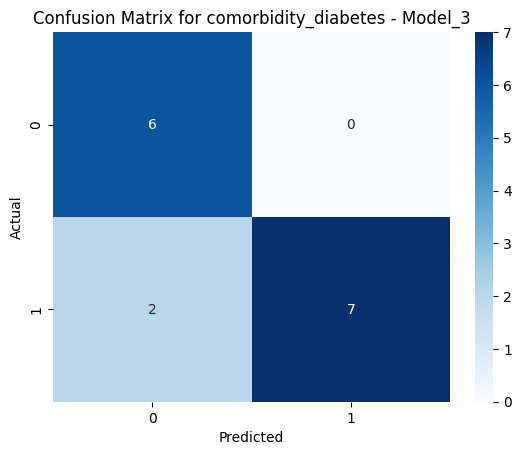

In [8]:
def plot_confusion_matrix(gt_df, pred_df, attribute, model_name):
    cm = confusion_matrix(gt_df[attribute], pred_df[attribute])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {attribute} - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Example: plot for all models for 'comorbidity_diabetes'
for model_name, pred_df in model_outputs.items():
    plot_confusion_matrix(ground_truth, pred_df, 'comorbidity_diabetes', model_name)
